In [2]:
import cv2
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from core.utils import IoU, assemble_data

### 1. 数据准备

In [3]:
# wider数据文件
anno_file = '/Users/shaotianyuan/DATA/WIDER/wider_face_split/wider_face_train_bbx_gt.txt'
im_dir = '/Users/shaotianyuan/DATA/WIDER/WIDER_train/images'

# pnet data image
pos_save_dir = './data_set/train/12/positive'
part_save_dir = './data_set/train/12/part'
neg_save_dir = './data_set/train/12/negative'

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.mkdir(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.mkdir(neg_save_dir)

# pnet anno
f1 = open(os.path.join('./anno_store', 'pos_12.txt'), 'w')
f2 = open(os.path.join('./anno_store', 'neg_12.txt'), 'w')
f3 = open(os.path.join('./anno_store', 'part_12.txt'), 'w')

# count
p_idx = 0
n_idx = 0
d_idx = 0
idx = 0
box_idx = 0

In [4]:
with open(anno_file) as f:
    annotations = f.readlines()
    
num = len(annotations)
print(num)

185184


In [5]:
# data： image_path(0), face_count(1), boxes(x, y, w, h)(2:)

n = -1
lines = []
for annotation in annotations:
    annotation = annotation.strip().split(' ')
    if annotation[0][-3:] == 'jpg':
        lines.append(annotation)
        n += 1
    else:
        annotation = list(map(int, annotation))
        lines[n].extend(annotation[:4])
print(len(lines))
print(lines[:2])

12880
[['0--Parade/0_Parade_marchingband_1_849.jpg', 1, 449, 330, 122, 149], ['0--Parade/0_Parade_Parade_0_904.jpg', 1, 361, 98, 263, 339]]


[6068, 7204, 1005]


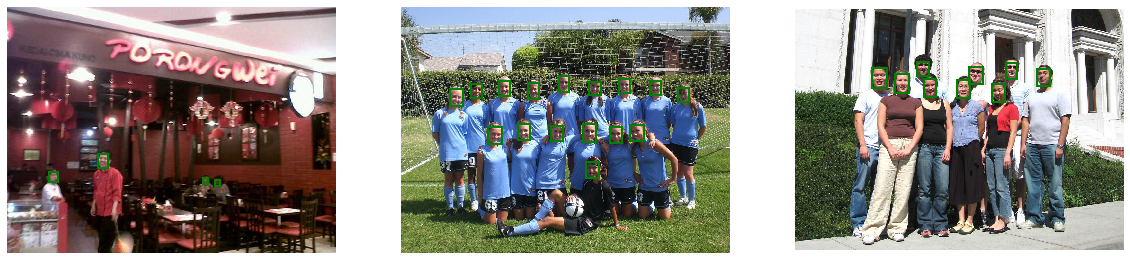

In [7]:
def my_show(lines,nums):
    lst = []
    fig, ax = plt.subplots(figsize=(20,10))
    for i in range(nums):
        n = random.randint(0,len(lines))
        lst.append(n)
        img = np.array(Image.open(os.path.join(im_dir,lines[n][0])))
        ax = plt.subplot(1, nums, i + 1)
        ax.imshow(img)
        
        loc = np.array(lines[n][2:]).reshape(-1, 4)
        for x1, y1, x2, y2 in loc:
            rect = plt.Rectangle((x1, y1), x2, y2, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.axis('off')
    print(lst)
        
        
my_show(lines, 3)

In [21]:
for annotation in lines[:200]:
    im_path = os.path.join(im_dir, annotation[0])
    bbox = list(map(float, annotation[2:]))
    boxes = np.array(bbox, dtype=np.int32).reshape(-1, 4)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    
    img = cv2.imread(im_path)
    idx += 1
    if idx % 100 == 0:
        print(idx, "images done")

    height, width, channel = img.shape
    
    # 1. 负样本，要求：iou 0.3以下， 固定数量 50个

    neg_num = 0
    while neg_num < 50:
        size = np.random.randint(12, min(width, height) / 2)
        nx = np.random.randint(0, width - size)
        ny = np.random.randint(0, height - size)
        crop_box = np.array([nx, ny, nx + size, ny + size])

        Iou = IoU(crop_box, boxes)

        cropped_im = img[ny: ny + size, nx: nx + size, :]
        resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

        if np.max(Iou) < 0.3:
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0 %.2f %.2f %.2f %.2f\n' % (0, 0, 0, 0))
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
            neg_num += 1
    
    # 2. 难负样本，要求：iou 0.3以下 且与gt有交集， 整体数量 1: 5左右
            
    for box in boxes:
        x1, y1, x2, y2 = box
        w = x2 - x1 + 1
        h = y2 - y1 + 1

        # 忽略比较小的脸

        if max(w, h) < 40 or x1 < 0 or y1 < 0:
            continue
            
        for i in range(5):
            size = np.random.randint(12, min(width, height) / 2)

            delta_x = np.random.randint(max(-size, -x1), w)
            delta_y = np.random.randint(max(-size, -y1), h)
            nx1 = max(0, x1 + delta_x)
            ny1 = max(0, y1 + delta_y)

            if nx1 + size > width or ny1 + size > height:
                continue
            crop_box = np.array([nx1, ny1, nx1 + size, ny1 + size])
            Iou = IoU(crop_box, boxes)

            cropped_im = img[ny1: ny1 + size, nx1: nx1 + size, :]
            resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

            if np.max(Iou) < 0.3:
                # Iou with all gts must below 0.3
                save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
                f2.write(save_file + ' 0 %.2f %.2f %.2f %.2f\n' % (0, 0, 0, 0))
                cv2.imwrite(save_file, resized_im)
                n_idx += 1
                
    # 3.正样本，要求：iou 0.65 以上, 数量 1: 20
    
        for i in range(20):
            size = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))

            # delta here is the offset of box center
            delta_x = np.random.randint(-w * 0.2, w * 0.2)
            delta_y = np.random.randint(-h * 0.2, h * 0.2)

            nx1 = max(x1 + w / 2 + delta_x - size / 2, 0)
            ny1 = max(y1 + h / 2 + delta_y - size / 2, 0)
            nx2 = nx1 + size
            ny2 = ny1 + size

            if nx2 > width or ny2 > height:
                continue
            crop_box = np.array([nx1, ny1, nx2, ny2])

            offset_x1 = (x1 - nx1) / float(size)
            offset_y1 = (y1 - ny1) / float(size)
            offset_x2 = (x2 - nx2) / float(size)
            offset_y2 = (y2 - ny2) / float(size)

            cropped_im = img[int(ny1): int(ny2), int(nx1): int(nx2), :]
            resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

            box_ = box.reshape(1, -1)
        

            if IoU(crop_box, box_) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1
    
    # 4.难正样本，要求： 0.4 <= iou < 0.65  
    
            elif IoU(crop_box, box_) >= 0.4:  
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1
        box_idx += 1
        
f1.close()
f2.close()
f3.close()
print()
print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))

100 images done
200 images done

200 images done, pos: 3162 part: 8209 neg: 12502


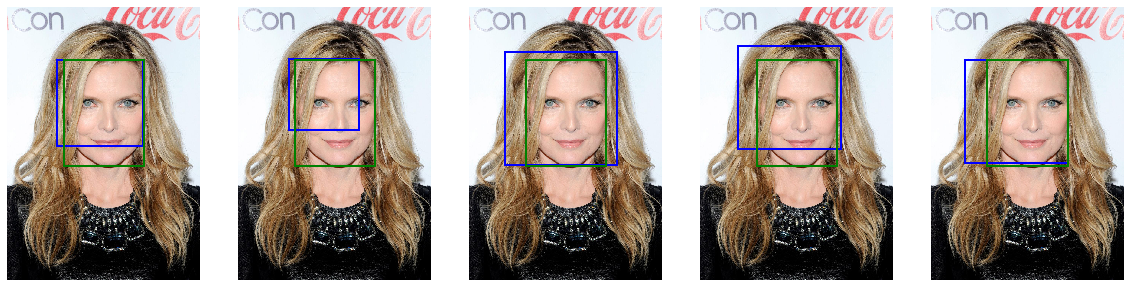

In [22]:
fig,ax = plt.subplots(figsize=(20, 10))

annotation = lines[2323]
im_path = os.path.join(im_dir, annotation[0])
x1, y1, w, h = list(map(float, annotation[2:]))

for i in range(5):
    size = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))
    delta_x = np.random.randint(-w * 0.2, w * 0.2)
    delta_y = np.random.randint(-h * 0.2, h * 0.2)
    nx1 = max(x1 + w / 2 + delta_x - size / 2, 0)
    ny1 = max(y1 + h / 2 + delta_y - size / 2, 0)

    crop_box = [nx1, ny1, size, size]

    img = np.array(Image.open(im_path))
    ax = plt.subplot(1, 5, i + 1)
    rect1 = plt.Rectangle((crop_box[0], crop_box[1]), crop_box[2], crop_box[3], linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect1)
    rect2 = plt.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect2)
    ax.axis('off')
    ax.imshow(img)

In [23]:
anno_list = ['./anno_store/neg_12.txt', './anno_store/part_12.txt', './anno_store/pos_12.txt']
imglist_filename = './anno_store/imglist_anno_12.txt'
chose_count = assemble_data(imglist_filename, anno_list)
chose_count

./anno_store/neg_12.txt
./anno_store/part_12.txt
./anno_store/pos_12.txt


23873